### ⚠️ Roteiro para executar códigos do notebook no Google Colab(oratory)_


**PASSO 1:** Acessar https://colab.research.google.com/ $\to$ `Upload` $\to$ `escolher arquivo .ipynb`

**PASSO 2:** `Barra lateral esquerda` $\to$ `Icone de arquivo` $\to$ `Icone de upload` $\to$ `escolher arquivo auxiliar` (ex. `aux.py`)

**PASSOS 3:** ver célula a seguir...

In [ ]:
#### PASSO 3: INSTALAR versão MXNET
#### Descomente a linha abaixo e execute

#!pip install mxnet==1.8.0 #(ou 1.7.0.post1)

## Recapitulando o modelo conservador...

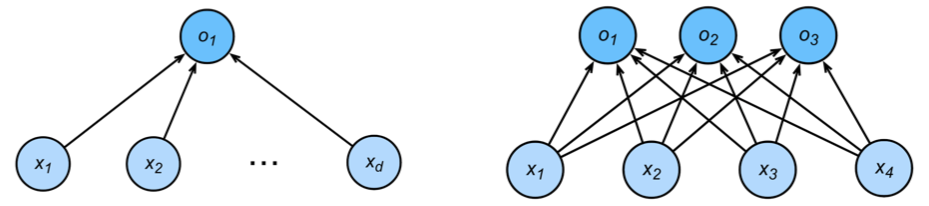


$\mathbf{o} = \mathbf{W} \mathbf{x} + \mathbf{b}$

(i) **Regressão linear**: $\hat{\mathbf{y}} = \mathbf{o}$ (valor $\in \mathbb{R}$)

(ii) **Regressão Softmax (ou Logística)**: $\hat{\mathbf{y}} = \mathrm{softmax}(\mathbf{o})$ (probabilidades)

## ... e (iii) classificando com função de ativação

$\hat{\mathbf{y}} =
  \begin{cases}
    1   & \quad \text{if } o > 0\\
    -1  & \quad \text{caso contrário}
  \end{cases}
$

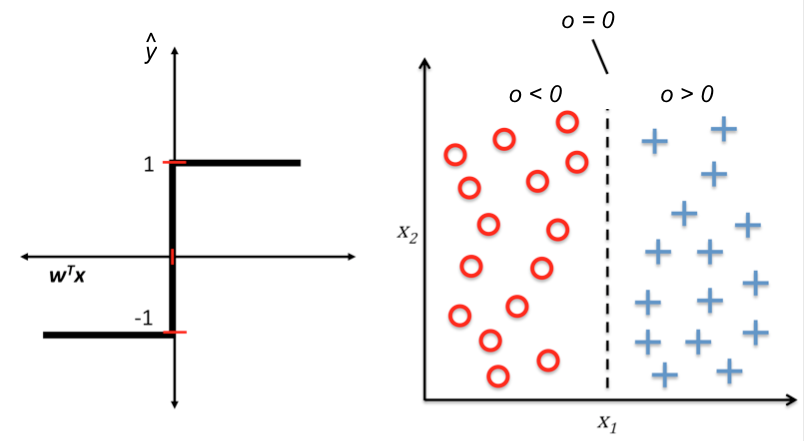

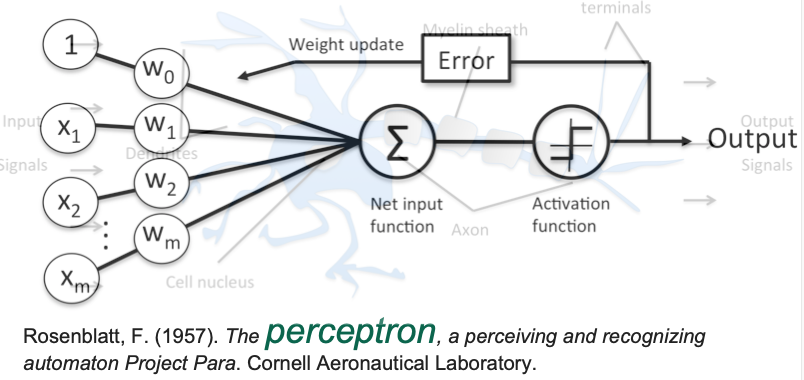

## Exemplo do Perceptron com dados fictícios

In [30]:
import mxnet as mx
from mxnet import nd, autograd
import matplotlib.pyplot as plt
import numpy as np
mx.random.seed(1)

In [31]:
## geração de dados linearmente separáveis com uma margem de separação epsilon
def getfake(samples, dimensions, epsilon):
    wfake = nd.random_normal(shape=(dimensions))   
    bfake = nd.random_normal(shape=(1))            
    wfake = wfake / nd.norm(wfake)                 # rescalando os pesos para 1 unidade

    X = nd.zeros(shape=(samples, dimensions))
    Y = nd.zeros(shape=(samples))

    i = 0
    while (i < samples):
        tmp = nd.random_normal(shape=(1,dimensions))
        margin = nd.dot(tmp, wfake) + bfake
        if (nd.norm(tmp).asscalar() < 3) & (abs(margin.asscalar()) > epsilon):
            X[i,:] = tmp[0]
            Y[i] = 1 if margin.asscalar() > 0 else -1
            i += 1
    return X, Y

## Funções para plotagem
def plotdata(X,Y):
    for (x,y) in zip(X,Y):
        if (y.asscalar() == 1):
            plt.scatter(x[0].asscalar(), x[1].asscalar(), color='r')
        else:
            plt.scatter(x[0].asscalar(), x[1].asscalar(), color='b')

# ...plotagem de curvas de contorno
def plotscore(w,d):
    xgrid = np.arange(-3, 3, 0.02)
    ygrid = np.arange(-3, 3, 0.02)
    xx, yy = np.meshgrid(xgrid, ygrid)
    zz = nd.zeros(shape=(xgrid.size, ygrid.size, 2))
    zz[:,:,0] = nd.array(xx)
    zz[:,:,1] = nd.array(yy)
    vv = nd.dot(zz,w) + d
    CS = plt.contour(xgrid,ygrid,vv.asnumpy())
    plt.clabel(CS, inline=1, fontsize=10)

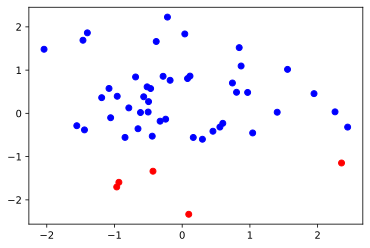

In [32]:
## Exemplo de visualização dos dados gerados artificialmente 
X, Y = getfake(50, 2, 0.3) #com epsilon 0.3
plotdata(X,Y)
plt.show()

In [33]:
## Definição da função Perceptron
def perceptron(w,b,x,y):
    if (y * (nd.dot(w,x) + b)).asscalar() <= 0: #ou seja, errou a classe correta...
        #...atualiza pessos
        w += y * x
        b += y
        return 1
    else:
        #...senão, mantém como está.
        return 0

Erro encontrado e atualização de parametros
dados   [-2.0401056  1.482131 ], rotulo -1.0
pesos [ 2.0401056 -1.482131 ], bias  -1.0


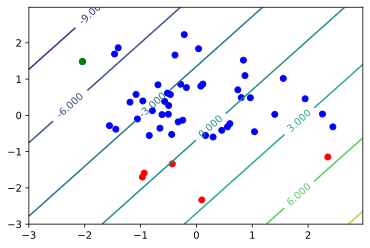

Erro encontrado e atualização de parametros
dados   [ 1.040828   -0.45256865], rotulo -1.0
pesos [ 0.9992776 -1.0295624], bias  -2.0


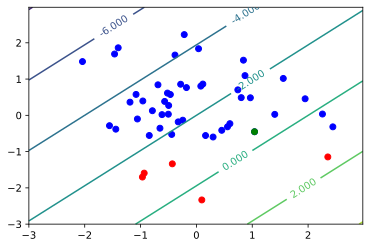

Erro encontrado e atualização de parametros
dados   [-0.934901  -1.5937569], rotulo 1.0
pesos [ 0.06437659 -2.6233191 ], bias  -1.0


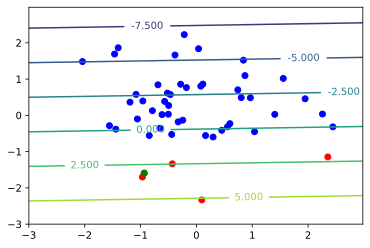

Erro encontrado e atualização de parametros
dados   [-0.84411263 -0.55587363], rotulo -1.0
pesos [ 0.9084892 -2.0674455], bias  -2.0


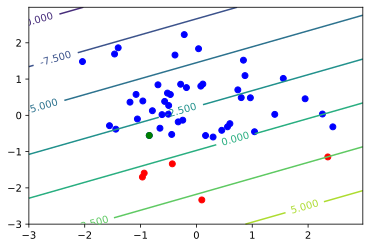

Erro encontrado e atualização de parametros
dados   [ 2.4434173  -0.31752375], rotulo -1.0
pesos [-1.5349281 -1.7499218], bias  -3.0


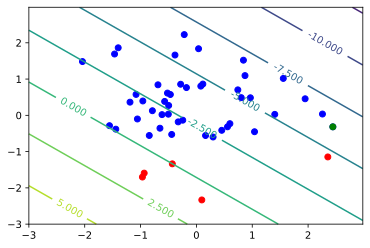

In [34]:
## Execução sobre cada exemplo para visualizar atualização dos pesos
w = nd.zeros(shape=(2))
b = nd.zeros(shape=(1))
for (x,y) in zip(X,Y):
    res = perceptron(w,b,x,y)
    if (res == 1):
        print('Erro encontrado e atualização de parametros')
        print('dados   {}, rotulo {}'.format(x.asnumpy(),y.asscalar()))
        print('pesos {}, bias  {}'.format(w.asnumpy(),b.asscalar()))
        plotscore(w,b)
        plotdata(X,Y)
        plt.scatter(x[0].asscalar(), x[1].asscalar(), color='g')
        plt.show()

## Problemas do modelo conservador

1. Conforme visto, os outputs possuem relação direta de **linearidade** com as entradas. Isso resolve muitos problemas, mas considerar que entrada e saída possuem sempre uma relação linear é uma **suposição MUITO forte e arriscada (suposição de MONOTONICIDADE)**. 

_Exemplo 1_: garantia de quitação de débito ($y$ - variável dependente) baseada no crescimento da renda ($x$ - variável independente).

_Exemplo 2_: rotular como gato vs. cachorro ($y$ - variável dependente) baseando-se na intensidade dos pixels ($x$ - variável independente).

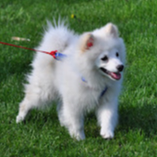

De fato, o significado de qualquer pixel depende complexamente de seu contexto (os valores dos pixels ao redor).

2. Não resolve problemas de classificação onde as **classes não são linearmente separáveis**.

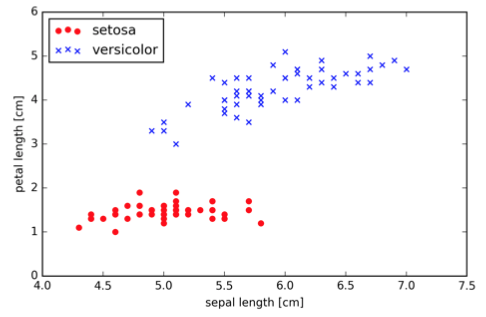

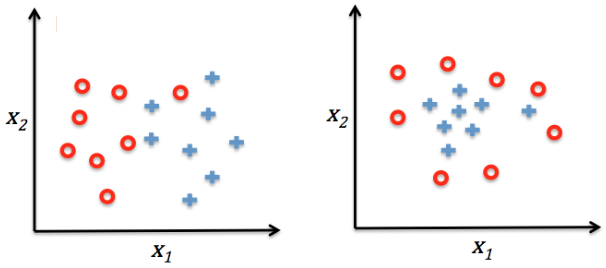

# Solução: Perceptron Multicamadas (MLP)

## Inclusão de camadas intermediárias (ESCONDIDAS) entre a entrada e a saída da rede

Embora possa existir uma representação dos dados que leve em conta as interações relevantes entre as características existentes, sobre as quais um modelo linear seria adequado, a grande questão é que **simplesmente não sabemos como calculá-lo manualmente**. 

Com **redes neurais profundas**, utilizamos dados observacionais para **aprender conjuntamente tanto uma representação através de camadas ocultas como um preditor linear** que atue sobre essa representação.

**Exemplo: Perceptron de 2 camadas, sendo 1 camada escondida.**



\begin{split}\begin{aligned}
    \mathbf{H} & = \mathbf{X} \mathbf{W}^{(1)} + \mathbf{b}^{(1)}, \\
    \mathbf{O} & = \mathbf{H}\mathbf{W}^{(2)} + \mathbf{b}^{(2)}.
\end{aligned}\end{split}

Até aqui, nada muda ==> relação linear das saídas de outra relação linear das entradas continua sendo uma relação linear das entradas! $\mathbf{O} = (\mathbf{X} \mathbf{W}^{(1)} + \mathbf{b}^{(1)})\mathbf{W}^{(2)} + \mathbf{b}^{(2)} = \mathbf{X} \mathbf{W}^{(1)}\mathbf{W}^{(2)} + \mathbf{b}^{(1)} \mathbf{W}^{(2)} + \mathbf{b}^{(2)} = \mathbf{X} \mathbf{W} + \mathbf{b}.$

## Logo, precisamos considerar a adição de uma função de ativação não-linear $\sigma$

\begin{split}\begin{aligned}
    \mathbf{H} & = \sigma(\mathbf{X} \mathbf{W}^{(1)} + \mathbf{b}^{(1)}), \\
    \mathbf{O} & = \mathbf{H}\mathbf{W}^{(2)} + \mathbf{b}^{(2)}.\\
\end{aligned}\end{split}

## Sobre profundidade e capacidade de aprendizado do MLP

1. Com **uma única camada escondida** + **quantidade MUITO GRANDE de nós** (e o conjunto certo de pesos) ===> **é possível modelar qualquer função**; o difícil é aprendê-la realmente!

2. Com mais camadas escondidas (**maior profundidade**), não necessitamos de tantos nós para modelar essas mesmas funções "difíceis"; ou seja ===> modelo mais compacto!

## Funções de ativação 

In [35]:
%matplotlib inline
from mxnet import autograd, nd
from matplotlib import pyplot as plt
from IPython import display

####
# Auxiliar: definie o formato 'svg' para plotagens
def use_svg_display():
    display.set_matplotlib_formats('svg')

###
# Auxiliar: definie tamanho da figura a ser plotada
def set_figsize(figsize=(3.5, 2.5)):
    use_svg_display()
    plt.rcParams['figure.figsize'] = figsize

def xyplot(x_vals, y_vals, name):
    set_figsize(figsize=(5, 2.5))
    plt.plot(x_vals.asnumpy(), y_vals.asnumpy())
    plt.xlabel('x')
    plt.ylabel(name + '(x)')

### ReLU: _Rectified Linear Unit_

A mais popular para a camada intermediária/escondida: simples, boa performance e derivada é bem comportada!

$$\mathrm{ReLU}(x) = \max(x, 0).$$


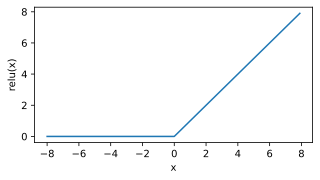

In [36]:
x = nd.arange(-8.0, 8.0, 0.1)
x.attach_grad()
with autograd.record():
    y = x.relu()
xyplot(x, y, 'relu')

#### Derivada do ReLU

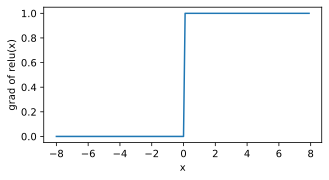

In [37]:
y.backward()
xyplot(x, x.grad, 'grad of relu')

### Sigmoid

Amplamente utilizada na camada de saída, quando queremos interpretar as saídas como probabilidades de problemas de classificação binária (caso especial do softmax). Gera resultados no intervalo $[0, 1]$.

$$\mathrm{sigmoid}(x) = \frac{1}{1 + \exp(-x)}.$$

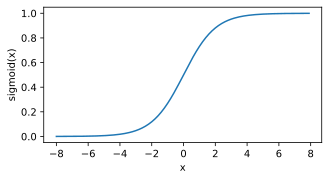

In [38]:
with autograd.record():
    y = x.sigmoid()
xyplot(x, y, 'sigmoid')

#### Derivada da Sigmoid 

$$\frac{d}{dx} \mathrm{sigmoid}(x) = \frac{\exp(-x)}{(1 + \exp(-x))^2} = \mathrm{sigmoid}(x)\left(1-\mathrm{sigmoid}(x)\right).$$


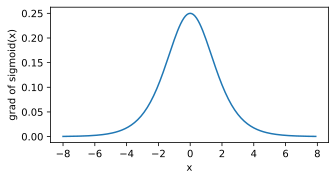

In [39]:
y.backward()
xyplot(x, x.grad, 'grad of sigmoid')

### Tanh: Tangente Hiperbólica

Semelhante à Sigmoid para intervalo $[-1, 1]$.

$$\text{tanh}(x) = \frac{1 - \exp(-2x)}{1 + \exp(-2x)}.$$

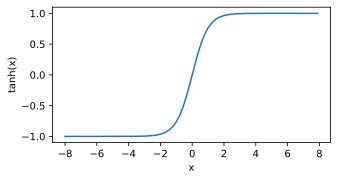

In [40]:
with autograd.record():
    y = x.tanh()
xyplot(x, y, 'tanh')

#### Derivada da Tanh 

$$\frac{d}{dx} \mathrm{tanh}(x) = 1 - \mathrm{tanh}^2(x).$$



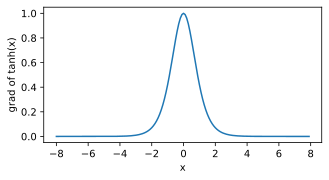

In [41]:
y.backward()
xyplot(x, x.grad, 'grad of tanh')

# Implementação da MLP

In [42]:
%matplotlib inline
from mxnet import gluon, np, npx
import aux as aux

npx.set_np()

## ESTUDO DE CASO: dataset _Fashion-MNIST_
Link: https://github.com/zalandoresearch/fashion-mnist

São 10 classes, cada uma representa 3 linhas da imagem

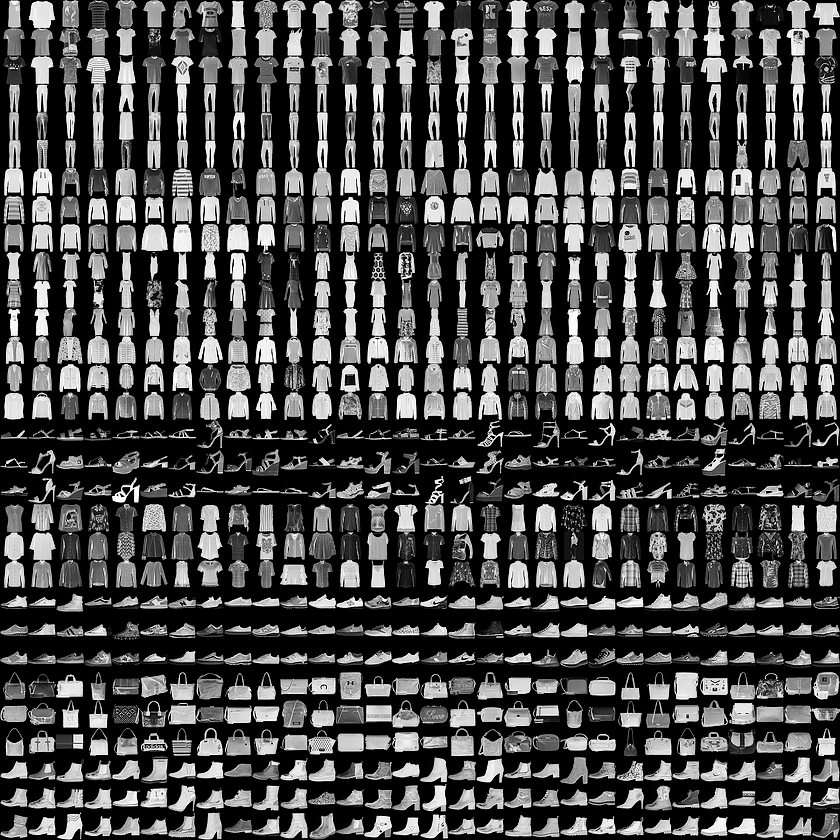

In [43]:
batch_size = 256
train_iter, test_iter = aux.load_data_fashion_mnist(batch_size)

### Inicializar parâmetros do modelo

In [44]:
num_inputs, num_outputs, num_hiddens = 784, 10, 256

W1 = np.random.normal(scale=0.01, size=(num_inputs, num_hiddens))
b1 = np.zeros(num_hiddens)
W2 = np.random.normal(scale=0.01, size=(num_hiddens, num_outputs))
b2 = np.zeros(num_outputs)
params = [W1, b1, W2, b2]

for param in params:
    param.attach_grad()

### Função de ativação: ReLU

In [45]:
def relu(X):
    return np.maximum(X, 0)

### Definição do MODELO DE APRENDIZADO

In [47]:
def net(X):
    X = X.reshape((-1, num_inputs))
    H = relu(np.dot(X, W1) + b1) # ativação da camada escondida
    return np.dot(H, W2) + b2

### A função de custo

In [48]:
loss = gluon.loss.SoftmaxCrossEntropyLoss()

### TREINAMENTO DO MODELO (APRENDIZADO)

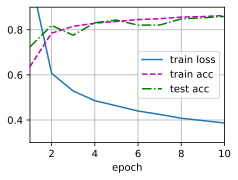

In [49]:
num_epochs, lr = 10, 0.1
aux.train_ch3(net, train_iter, test_iter, loss, num_epochs,
              lambda batch_size: aux.sgd(params, lr, batch_size))

### Previsão de um exemplo novo

In [ ]:
aux.predict_ch3(net, test_iter)

## Versão com `mxnet.gluon`

In [50]:
from mxnet import gluon, init, npx
from mxnet.gluon import nn
import aux as aux

npx.set_np()

In [51]:
net = nn.Sequential()
net.add(nn.Dense(256, activation='relu'), nn.Dense(10))
net.initialize(init.Normal(sigma=0.01))

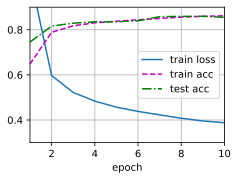

In [52]:
batch_size, lr, num_epochs = 256, 0.1, 10
loss = gluon.loss.SoftmaxCrossEntropyLoss()
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': lr})

train_iter, test_iter = aux.load_data_fashion_mnist(batch_size)
aux.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

# Um pouco de entendimento do que há por trás...


## 1. Forward Propagation

Refere-se ao cálculo e armazenamento de variáveis intermediárias (incluindo as saídas) de uma rede neuronal a partir da camada de entrada até a camada de saída.






## 2. Backpropagation (etapa mais difícil)

Método de cálculo do gradiente dos parâmetros da rede neuronal. O método atravessa a rede em ordem inversa, desde a saída até a camada de entrada, de acordo com a regra da cadeia do Cálculo Diferencial.

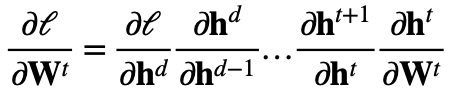

**Disfarçado em pacotes/funções já prontas de AUTOGRAD**

```python
from mxnet import autograd
...

def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):
    ...
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        ...
    train_loss, train_acc = train_metrics
    ...
```

```python
def train_epoch_ch3(net, train_iter, loss, updater):
    ...
    for X, y in train_iter:
        # Compute gradients and update parameters
        with autograd.record():
            y_hat = net(X)
            l = loss(y_hat, y)
        l.backward()
        ...
```


### Um depende do outro durante o aprendizado

Forward $\implies$ Backward $\implies$ Forward $\implies$  Backward $\implies$  ...


## 3. Efeitos colaterais preocupantes

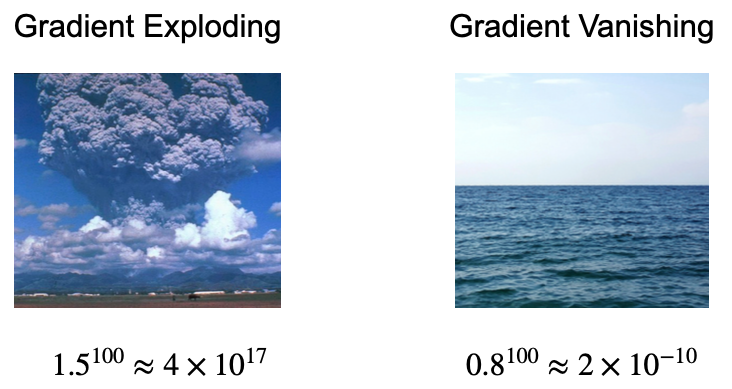



### Como evitar/minimizar esses efeitos? 

Extremo cuidado com a **INICIALIZAÇÃO DE PARÂMETROS** $\implies$ **ESTABILIZAÇÃO NUMÉRICA**

# Referências para estudo

## Seções 4.1, 4.2 e 4.3 de [Dive into Deep Learning](https://d2l.ai/index.html)

### OBS: para aprofundar no entendimento do que há por trás:
**Forward e Backward: seção 4.7**  
**Estabilização numérica: seção 4.8** 